## Librairies

In [2]:
import warnings
warnings.filterwarnings("ignore")

import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
today=date.today()

import sys
sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/xscale")
import xscale

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen


import matplotlib.pyplot as plt
params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)


## Dataset

### Format netcdf

In [ ]:
data_dir = '/store/CT1/hmg2840/lbrodeau/eNATL60/'
tfilename = sorted(glob.glob(data_dir+'eNATL60-BLBT02*-S/*/eNATL60-BLBT02*_1h_*_gridT-2D_*.nc'))
filename =tfilename[0]


In [ ]:
%time dsn=xr.open_mfdataset(tfilename)['sossheig']


In [ ]:
dsn

In [ ]:
print(dsn.nbytes/1e9)

### Format zarr

In [3]:
%time ds=xr.open_zarr('/store/albert7a/eNATL60/zarr/eNATL60-BLBT02-SSH-1h')
ds_sorted=ds.sortby('time_counter')

CPU times: user 133 ms, sys: 70.7 ms, total: 204 ms
Wall time: 2.73 s


In [4]:
ds

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 11688, x: 8354, y: 4729)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(240,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2010-01-19T00:30:00 ... 2009-09-17T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    nav_lat               (y, x) float32 dask.array<chunksize=(240, 480), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(240, 480), meta=np.ndarray>
    sossheig              (time_counter, y, x) float32 dask.array<chunksize=(240, 240, 480), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(240, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    TimeStamp:    24/03/2019 14:43:29 +0100
    description:  ocean T grid variables
    file_name:    eNATL60-BLBT02X_1h_20100101_20100125_gridT-2D_20100119-2010...
    ibegin:       0
    jbegin:       0
    name:         /scratch/tmp/5251284/eNATL60-BLBT02X_1h_20100101_20100125_g...
    ni:           8354
    nj:           10
    timeStamp:    2019-Mar-24 06:31:35 GMT
    title:        ocean T grid variables
    uuid:         80877374-74d2-468e-9fc6-d8cae8009094

In [5]:
print(ds.nbytes/1e9)

1847.304207184


In [6]:
ds_sorted=ds.sortby('time_counter')

### Selecting time frame and 1 point

In [7]:
ssh_FMA=ds_sorted.sel(time_counter=slice('2010-02-01','2010-04-30'))['sossheig']
ssh_FMA_1pt=ssh_FMA[:,2000,4000]
ssh_ASO=ds_sorted.sel(time_counter=slice('2009-08-01','2009-10-31'))['sossheig']
ssh_ASO_1pt=ssh_ASO[:,2000,4000]

### Xarray plotting capabilities

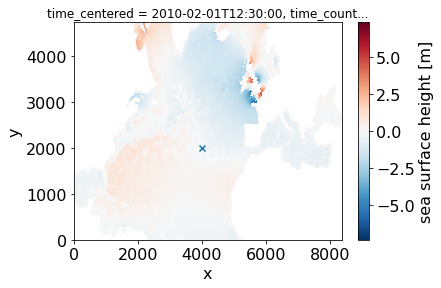

In [8]:
ssh_FMA[12].plot()
plt.scatter(4000,2000,marker='x')

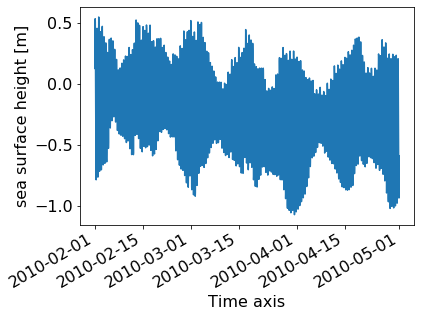

In [9]:
ssh_FMA_1pt.plot()

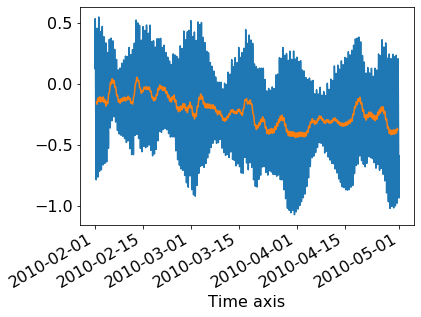

In [10]:
ssh_FMA_1pt.plot(label='full data')
ssh_FMA_1pt.rolling(time_counter=24,center=True).mean().plot(label='rolling daily mean')

## FFT decomposition and power spectral density computation

In [11]:
NPADDING = 2
SPtime_FMA = xfft.fft(ssh_FMA_1pt, dim='time_counter', dx=1., detrend='mean',nfft=ssh_FMA_1pt.shape[0]*NPADDING,tapering=True)
MEANPSD_FMA=xfft.psd(SPtime_FMA).load()
freqs_FMA=MEANPSD_FMA.f_time_counter.values
freqs_FMA = freqs_FMA[NPADDING::] 

SPtime_ASO = xfft.fft(ssh_ASO_1pt, dim='time_counter', dx=1., detrend='mean',nfft=ssh_ASO_1pt.shape[0]*NPADDING,tapering=True)
MEANPSD_ASO=xfft.psd(SPtime_ASO).load()
freqs_ASO=MEANPSD_ASO.f_time_counter.values
freqs_ASO = freqs_ASO[NPADDING::] 


Text(0.5, 1.0, 'Temporal Spectrum of SSH at one point')

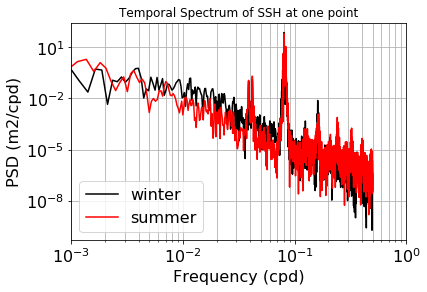

In [12]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cpd)')
plt.ylabel('PSD (m2/cpd)')
plt.legend()
plt.title('Temporal Spectrum of SSH at one point')

## Same computation for 100x100 points

### Computational ressources

In [13]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='demo',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(196)
cluster

In [14]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.4:37623 Dashboard: http://172.30.100.4:46688/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [15]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           9789449     hsw24     demo albert7a  R       0:11      1 n2311
           9789450     hsw24     demo albert7a  R       0:11      1 n2847
           9789451     hsw24     demo albert7a  R       0:11      1 n3011
           9789452     hsw24     demo albert7a  R       0:11      1 n2052
           9789453     hsw24     demo albert7a  R       0:11      1 n2053
           9789454     hsw24     demo albert7a  R       0:11      1 n2228
           9789455     hsw24     demo albert7a  R       0:11      1 n2229


### Data selection

In [ ]:
ssh_FMA_reg=ssh_FMA[:,2000:2100,4000:4100]
ssh_ASO_reg=ssh_ASO[:,2000:2100,4000:4100]
ssh_FMA[12].plot()
plt.plot([4000, 4100], [2000, 2000])
plt.plot([4000, 4100], [2100, 2100])
plt.plot([4000, 4000], [2000, 2100])
plt.plot([4100, 4100], [2000, 2100])


In [ ]:
NPADDING = 2
SPtime_FMA = xfft.fft(ssh_FMA_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_FMA_reg.shape[0]*NPADDING,tapering=True)
MEANPSD_FMA=xfft.psd(SPtime_FMA).mean(dim='x').mean(dim='y').load()
freqs_FMA=MEANPSD_FMA.f_time_counter.values
freqs_FMA = freqs_FMA[NPADDING::] 

SPtime_ASO = xfft.fft(ssh_ASO_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_ASO_reg.shape[0]*NPADDING,tapering=True)
MEANPSD_ASO=xfft.psd(SPtime_ASO).mean(dim='x').mean(dim='y').load()
freqs_ASO=MEANPSD_ASO.f_time_counter.values
freqs_ASO = freqs_ASO[NPADDING::] 


In [ ]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cpd)')
plt.ylabel('PSD (m2/cpd)')
plt.legend()
plt.title('Temporal Spectrum of SSH at one point')